In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

In [2]:
import requests
import zipfile


# URL of the bank marketing dataset
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
zip_file_path = 'bank+marketing.zip'
extracted_folder_path = '/Users/serdarc/Desktop/ml-zoomcamp'

# Step 1: Download the ZIP file if not already downloaded
if not os.path.exists(zip_file_path):
    response = requests.get(url)
    with open(zip_file_path, 'wb') as f:
        f.write(response.content)

# Step 2: Create a folder to extract the zip files
os.makedirs(extracted_folder_path, exist_ok=True)

# Step 3: Extract only the "bank.zip" from the main ZIP
with zipfile.ZipFile(zip_file_path, 'r') as z:
    z.extract('bank.zip', path=extracted_folder_path)

# Step 4: Now extract the contents of the "bank.zip"
bank_zip_path = os.path.join(extracted_folder_path, 'bank.zip')
with zipfile.ZipFile(bank_zip_path, 'r') as bank_zip:
    bank_zip.extractall(extracted_folder_path)

# Step 5: List all the files extracted to check for bank-full.csv
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)

['bank-names.txt', 'homework_4.ipynb', 'bank.csv', 'laptops.csv', '.DS_Store', 'homework_2.ipynb', 'bank.zip', 'bank+marketing.zip', 'homework_1.ipynb', 'bank-full.csv', 'homework_3.ipynb', 'MTA_Delays.ipynb', '.ipynb_checkpoints', '.git']


In [3]:

# Path to the bank-full.csv file
csv_file_path = os.path.join(extracted_folder_path, 'bank-full.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path, delimiter=';')  # Adjust the delimiter if needed

df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
columns_to_use = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 
    'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
    'previous', 'poutcome', 'y'
]

# Load only the required columns into a DataFrame
df = pd.read_csv(csv_file_path, delimiter=';', usecols=columns_to_use)

df

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,825,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,1729,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,5715,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,668,no,telephone,17,nov,508,4,-1,0,unknown,no


In [5]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [8]:
X = df[['balance', 'day', 'duration', 'previous']]  # Only the 4 numerical variables
y = df['y']  # Target variable

# Step 5: First, split the data into training (60%) and remaining (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Then, split the remaining 40% into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Print the sizes of the training, validation, and testing sets
print((X_train.shape, X_val.shape, X_test.shape), (y_train.shape, y_val.shape, y_test.shape))

# Step 6: Train the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 8: Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy * 100:.2f}%")

((27126, 4), (9042, 4), (9043, 4)) ((27126,), (9042,), (9043,))
Logistic Regression Model Accuracy: 88.49%


In [9]:
X

,balance,day,duration,previous
0,2143,5,261,0
1,29,5,151,0
2,2,5,76,0
3,1506,5,92,0
4,1,5,198,0
...,...,...,...,...
45206,825,17,977,0
45207,1729,17,456,0
45208,5715,17,1127,3
45209,668,17,508,0


In [10]:
# Question 1: ROC AUC feature importance
# ROC AUC could also be used to evaluate feature importance of numerical variables.

# Let's do that

# For each numerical variable, use it as score and compute AUC with the above_average variable
# Use the training dataset for that
# If your AUC is < 0.5, invert this variable by putting "-" in front

# (e.g. -df_train['engine_hp'])

# AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

# Which numerical variable (among the following 4) has the highest AUC?

# balance
# day
# duration
# previous

In [11]:
# Step 2: Initialize a dictionary to store AUC scores
auc_scores = {}

# Step 3: Calculate AUC for each numerical variable
for column in X_train.columns:
    auc = roc_auc_score(y_train, X_train[column])
    
    # If AUC is less than 0.5, negate the variable and recalculate AUC
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[column])
    
    auc_scores[column] = auc
    print(f"AUC for {column}: {auc:.3f}")

# Step 4: Find the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical variable with the highest AUC is: {best_feature} with an AUC of {auc_scores[best_feature]:.3f}")

AUC for balance: 0.592
AUC for day: 0.529
AUC for duration: 0.813
AUC for previous: 0.599

The numerical variable with the highest AUC is: duration with an AUC of 0.813


In [12]:
# Question 2: Training the model
# Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# What's the AUC of this model on the validation dataset? (round to 3 digits)

In [13]:
df_cleaned = df.drop(columns=['day', 'month'])

# # Step 2: Apply one-hot encoding to categorical columns
# categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'poutcome']
# df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)

# Step 3: Split the data into features (X) and target (y)
X = df_cleaned.drop(columns=['y'])  # Features (exclude the target 'y')
y = df_cleaned['y']  # Target variable

# Step 2: Split the data into training (60%) and remaining (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Split the remaining 40% into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Step 3: Apply DictVectorizer for one-hot encoding
dv = DictVectorizer(sparse=False)

# Convert training and validation datasets to dictionary format
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

# Fit and transform the training data, transform the validation data
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

# Step 4: Train logistic regression with the given parameters
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

# Step 5: Predict probabilities on the validation set
y_val_proba = model.predict_proba(X_val_encoded)[:, 1]  # Probability of the positive class (above_average=1)

# Step 6: Calculate AUC on the validation dataset
auc_val = roc_auc_score(y_val, y_val_proba)

# Step 7: Print the AUC rounded to 3 decimal places
print(f"Validation AUC: {auc_val:.3f}")

Validation AUC: 0.884


In [14]:
# Question 3: Precision and Recall
# Now let's compute precision and recall for our model.

# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# For each threshold, compute precision and recall
# Plot them
# At which threshold precision and recall curves intersect?

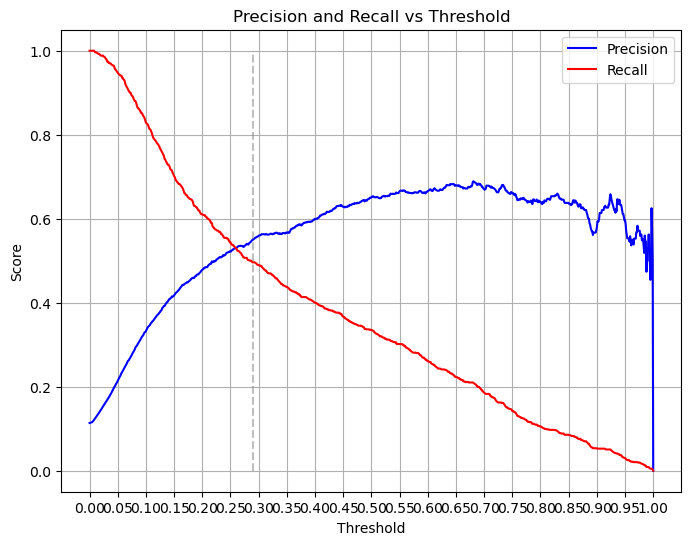

Precision and Recall intersect at threshold: 1.000


In [15]:
# Convert 'yes'/'no' labels in y_val to 1/0
y_val_binary = y_val.map({'yes': 1, 'no': 0})

# Step 1: Get predicted probabilities for the positive class
y_val_proba = model.predict_proba(X_val_encoded)[:, 1]

# Step 2: Increase granularity of thresholds
thresholds = np.arange(0.0, 1.001, 0.001)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_val_proba >= threshold).astype(int)
    
    # Calculate precision and recall (handle the zero_division case to avoid warnings)
    precision = precision_score(y_val_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_val_binary, y_pred_threshold)
    
    # Store the results
    precision_scores.append(precision)
    recall_scores.append(recall)

# Step 4: Plot precision and recall with more x-axis values
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='b')
plt.plot(thresholds, recall_scores, label='Recall', color='r')

# Increase the number of ticks on the x-axis for finer detail
plt.xticks(np.arange(0.0, 1.05, 0.05))  # Change step to 0.05 for better visualization
plt.vlines(x=0.29, ymin=0, ymax=1, colors='grey', linestyles='--', alpha=0.5)

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Find the intersection point
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)

# Find the index where the precision and recall curves are closest
intersection_index = np.argmin(np.abs(precision_scores - recall_scores))
intersection_threshold = thresholds[intersection_index]

# Print the threshold where precision and recall intersect
print(f"Precision and Recall intersect at threshold: {intersection_threshold:.3f}")

In [16]:
# Question 4: F1 score
# Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

# At which threshold F1 is maximal?

# 0.02
# 0.22
# 0.42
# 0.62

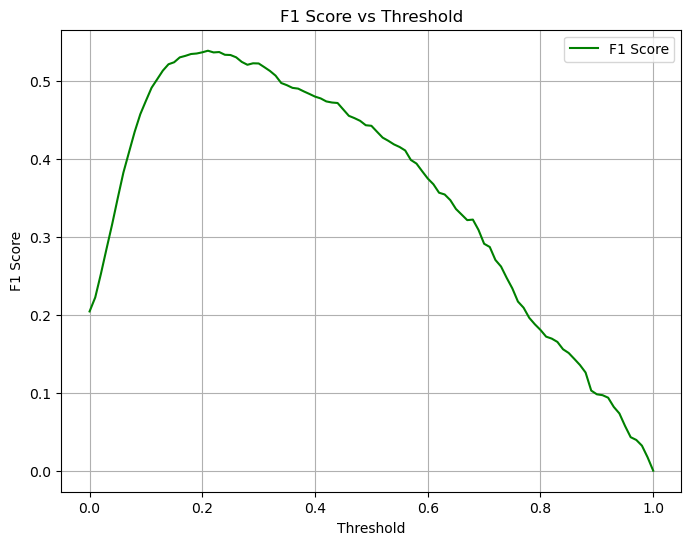

Threshold where F1 is maximal: 0.21


In [17]:
# # Convert 'yes'/'no' labels in y_val to 1/0
# y_val_binary = y_val.map({'yes': 1, 'no': 0})

# Step 1: Get predicted probabilities for the positive class
y_val_proba = model.predict_proba(X_val_encoded)[:, 1]

# Step 2: Initialize lists to store precision, recall, and F1 scores for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

# Step 3: Loop through thresholds and compute precision, recall, and F1 score
for threshold in thresholds:
    # Convert predicted probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_val_proba >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_val_binary, y_pred_threshold)
    
    # Calculate F1 score
    if (precision + recall) > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    
    # Store the results
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Step 4: Plot F1 score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='g')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Find the threshold with the maximum F1 score
f1_scores = np.array(f1_scores)
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]

# Print the threshold where F1 is maximal
print(f"Threshold where F1 is maximal: {max_f1_threshold:.2f}")

In [18]:
# Question 5: 5-Fold CV
# Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

# KFold(n_splits=5, shuffle=True, random_state=1)
# Iterate over different folds of df_full_train
# Split the data into train and validation
# Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# Use AUC to evaluate the model on validation
# How large is standard deviation of the scores across different folds?

In [36]:
df_cleaned = df.drop(columns=['day', 'month'])

KFold(n_splits=5, shuffle=True, random_state=1)


X = df_cleaned.drop(columns=['y'])  # Features (exclude the target 'y')
y = df_cleaned['y']  # Target variable

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize list to store AUC scores for each fold
auc_scores = []

# Iterate over each fold
for train_idx, val_idx in kf.split(X):
    # Split data into train and validation based on current fold indices
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Convert data to dictionary format for DictVectorizer
    X_train_dict = X_train.to_dict(orient='records')
    X_val_dict = X_val.to_dict(orient='records')
    
    # Apply DictVectorizer for one-hot encoding
    dv = DictVectorizer(sparse=False)
    
    # Fit on training data and transform both train and validation data
    X_train_encoded = dv.fit_transform(X_train_dict)
    X_val_encoded = dv.transform(X_val_dict)
    
    # Train logistic regression with the given parameters
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    # Predict probabilities for the validation set
    y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
    
    # Calculate AUC for the current fold
    auc = roc_auc_score(y_val, y_val_pred_proba)
    auc_scores.append(auc)

# Calculate and print the standard deviation of the AUC scores across the folds
auc_std = np.std(auc_scores)
print(f"AUC scores across folds: {auc_scores}")
print(f"Standard deviation of AUC scores: {auc_std:.4f}")

AUC scores across folds: [0.8925346583022048, 0.8788724176720326, 0.8880382546435457, 0.8948965632298966, 0.8897210515006493]
Standard deviation of AUC scores: 0.0055


In [37]:
# Question 6: Hyperparameter Tuning
# Now let's use 5-Fold cross-validation to find the best parameter C

# Iterate over the following C values: [0.01, 0.1, 0.5, 10]
# Initialize KFold with the same parameters as previously
# Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
# Which C leads to the best mean score?

In [38]:
df_cleaned = df.drop(columns=['day', 'month'])


X = df_cleaned.drop(columns=['y'])
y = df_cleaned['y']  # Target variable

kf = KFold(n_splits=5, shuffle=True, random_state=1)

C_values = [0.01, 0.1, 0.5, 10]

# Dictionary to store the mean and std for each C value
results = {}


for C in C_values:
    auc_scores = []  
    
    # Iterate over each fold
    for train_idx, val_idx in kf.split(X):
        # Split data into train and validation based on current fold indices
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Convert data to dictionary format for DictVectorizer
        X_train_dict = X_train.to_dict(orient='records')
        X_val_dict = X_val.to_dict(orient='records')
        
        # Apply DictVectorizer for one-hot encoding
        dv = DictVectorizer(sparse=False)
        
        # Fit on training data and transform both train and validation data
        X_train_encoded = dv.fit_transform(X_train_dict)
        X_val_encoded = dv.transform(X_val_dict)
        
        # Train logistic regression with the given C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_encoded, y_train)
        
        # Predict probabilities for the validation set
        y_val_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
        
        # Calculate AUC for the current fold
        auc = roc_auc_score(y_val, y_val_pred_proba)
        auc_scores.append(auc)
    
    # Calculate mean and std of AUC scores across the folds
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store the results (rounded to 3 decimal digits)
    results[C] = {'mean_auc': round(mean_auc, 3), 'std_auc': round(std_auc, 3)}

# Find the best C based on the highest mean AUC score
best_C = max(results, key=lambda x: results[x]['mean_auc'])

# Print the results
for C, metrics in results.items():
    print(f"C={C}: Mean AUC={metrics['mean_auc']}, Std AUC={metrics['std_auc']}")

print(f"\nBest C value: {best_C} with Mean AUC={results[best_C]['mean_auc']}")

C=0.01: Mean AUC=0.887, Std AUC=0.006
C=0.1: Mean AUC=0.889, Std AUC=0.006
C=0.5: Mean AUC=0.889, Std AUC=0.006
C=10: Mean AUC=0.889, Std AUC=0.006

Best C value: 0.1 with Mean AUC=0.889
